# Render some images

Have some tests for expected intrinsics (in preparation to match w/ real)

In [1]:
import dataclasses as dc

from PIL import Image
import numpy as np

from pydrake.all import (
    CameraInfo,
    ClippingRange,
    ColorRenderCamera,
    GeometryId,
    ImageRgba8U,
    MakeRenderEngineVtk,
    Mesh,
    PerceptionProperties,
    RenderCameraCore,
    RenderEngineVtkParams,
    RenderLabel,
    RigidTransform,
    RotationMatrix,
)

In [2]:
mesh_file = "pyramid_lowpoly.obj"

In [3]:
renderer = MakeRenderEngineVtk(
    RenderEngineVtkParams(
        default_diffuse=[1, 1, 1, 1],
        # default_clear_color=[0, 0, 0],  # Needs binding :(
    ),
)
geometry_id = GeometryId.get_new_id()
perception = PerceptionProperties()
perception.AddProperty("label", "id", RenderLabel(0))
renderer.RegisterVisual(
    geometry_id,
    shape=Mesh(mesh_file),
    properties=perception,
    X_WG=RigidTransform(),
    needs_updates=False,
);

In [4]:
width = 128
height = 128
fov_y = np.pi / 4

core = RenderCameraCore(
    "meh",
    CameraInfo(width, height, fov_y),
    ClippingRange(0.0001, 100.0),
    RigidTransform(),
)
color_camera = ColorRenderCamera(core, False)
# Allocate image.
rgb = ImageRgba8U(width, height)

K = core.intrinsics().intrinsic_matrix()
print(K)

[[154.50966799   0.          63.5       ]
 [  0.         154.50966799  63.5       ]
 [  0.           0.           1.        ]]


In [5]:
I3 = np.eye(3)
R_z90 = np.array([
    [0, 1, 0],
    [-1, 0, 0],
    [0, 0, 1],
])

In [6]:
@dc.dataclass
class Setup:
    p_WC: np.ndarray
    R_WC: np.ndarray

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[  0.   0. -10.]


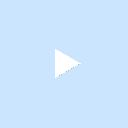

/tmp/pyramid_render_0.png


[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[  1.   0. -10.]


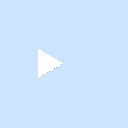

/tmp/pyramid_render_1.png


[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[  0.   1. -10.]


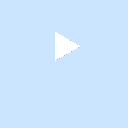

/tmp/pyramid_render_2.png


[[ 0  1  0]
 [-1  0  0]
 [ 0  0  1]]
[  0.   0. -10.]


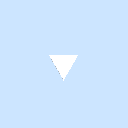

/tmp/pyramid_render_3.png




In [7]:
z = -10.0
setups = [
    Setup([0, 0, z], I3),
    Setup([1, 0, z], I3),
    Setup([0, 1, z], I3),
    Setup([0, 0, z], R_z90),
]

for i, setup in enumerate(setups):
    p_WC = np.asarray(setup.p_WC)
    R_WC = np.asarray(setup.R_WC)
    X_WC = RigidTransform(
        R=RotationMatrix(R_WC),
        p=p_WC,
    )
    print(R_WC)
    print(p_WC)
    renderer.UpdateViewpoint(X_WC)
    renderer.RenderColorImage(color_camera, rgb)
    pil_rgb = Image.fromarray(rgb.data)
    display(pil_rgb)
    save_file = f"/tmp/pyramid_render_{i}.png"
    pil_rgb.save(save_file)
    print(save_file)
    print("\n")